## Домашнее задание
### Предобработка изображений для использования в нейросети

In [2]:
import tensorflow as tf

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Загрузка датасета

In [4]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228818944/228813984 [==============================] - 12s 0us/step
/home/kbuilder/.keras/datasets/flower_photos


In [5]:
for item in data_root.iterdir():
    print(item)

/home/kbuilder/.keras/datasets/flower_photos/sunflowers
/home/kbuilder/.keras/datasets/flower_photos/daisy
/home/kbuilder/.keras/datasets/flower_photos/LICENSE.txt
/home/kbuilder/.keras/datasets/flower_photos/roses
/home/kbuilder/.keras/datasets/flower_photos/tulips
/home/kbuilder/.keras/datasets/flower_photos/dandelion


In [6]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [7]:
all_image_paths[:10]

['/home/kbuilder/.keras/datasets/flower_photos/tulips/16732302779_8aa56f255d_n.jpg',
 '/home/kbuilder/.keras/datasets/flower_photos/sunflowers/21728822928_9f6817325a_n.jpg',
 '/home/kbuilder/.keras/datasets/flower_photos/daisy/8085329197_41d53a21e2_n.jpg',
 '/home/kbuilder/.keras/datasets/flower_photos/roses/14573732424_1bb91e2e42_n.jpg',
 '/home/kbuilder/.keras/datasets/flower_photos/dandelion/9726260379_4e8ee66875_m.jpg',
 '/home/kbuilder/.keras/datasets/flower_photos/sunflowers/19710076021_f5bb162540.jpg',
 '/home/kbuilder/.keras/datasets/flower_photos/roses/15821959372_518b9dcf57_n.jpg',
 '/home/kbuilder/.keras/datasets/flower_photos/sunflowers/9699724719_a8439cc0fd_n.jpg',
 '/home/kbuilder/.keras/datasets/flower_photos/roses/6936225976_a91b60d8c2_m.jpg',
 '/home/kbuilder/.keras/datasets/flower_photos/sunflowers/1880606744_23e3dc4f6b_n.jpg']

### Изучение данных

In [8]:
import os
attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [9]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])


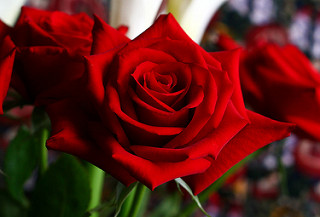

Image (CC BY 2.0)  by liz west



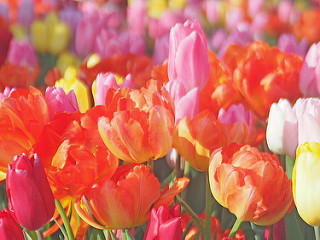

Image (CC BY 2.0)  by T.Kiya



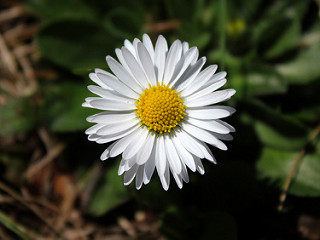

Image (CC BY 2.0)  by Scott Ellis



In [10]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()

### Определение меток для каждого изображения

In [11]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [12]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [13]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [4, 3, 0, 2, 1, 3, 2, 3, 2, 3]


### Загрузка и форматирование изображений

In [14]:
img_path = all_image_paths[0]
img_path

'/home/kbuilder/.keras/datasets/flower_photos/tulips/16732302779_8aa56f255d_n.jpg'

In [15]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


Преобразуем в тензор изображения:

In [16]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(212, 320, 3)
<dtype: 'uint8'>


Изменим размер для нашей модели:

In [17]:
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())


(192, 192, 3)
0.0
1.0


Обернём их в простые функции для будущего использования.

In [18]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range
    return image

In [19]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

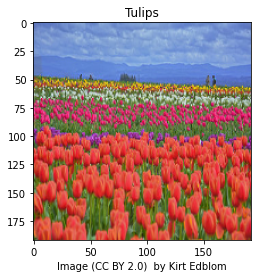

In [20]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

## Сборка tf.data.Dataset

In [21]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [22]:
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


In [23]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

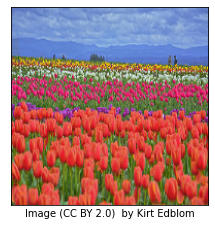

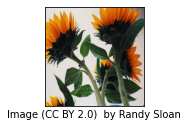

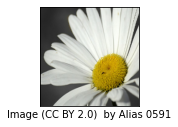

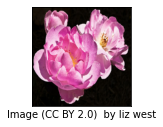

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))
    plt.show()

### Датасет пар 

In [25]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [26]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

tulips
sunflowers
daisy
roses
dandelion
sunflowers
roses
sunflowers
roses
sunflowers


Поскольку датасеты следуют в одном и том же порядке, мы можем просто собрать их вместе при помощи функции zip в набор данных пары `(image, label)`:

In [27]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

`Shapes` и `types` нового датасета это кортежи размерностей и типов описывающие каждое поле:

In [28]:
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [29]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# Кортежи распаковываются в позиционные аргументы отображаемой функции
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

### Обучение существующей модели нейронной сети

In [30]:
BATCH_SIZE = 32

# Установка размера буфера перемешивания, равного набору данных, гарантирует
# полное перемешивание данных.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` позволяет датасету извлекать пакеты в фоновом режиме, во время обучения модели.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

### Передача набора данных в модель

In [32]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

9412608/9406464 [==============================] - 1s 0us/step


In [33]:
def change_range(image,label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

In [34]:
image_batch, label_batch = next(iter(keras_ds))

In [35]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


In [36]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

In [37]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.010125087
max logit: 0.83786047

Shape: (32, 5)


Скомпилируем модель чтобы описать процесс обучения:

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

Есть две переменные для обучения -  Dense `weights` и `bias`:

In [39]:
len(model.trainable_variables)

2

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


Мы готовы обучать модель.

In [41]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [42]:
model.fit(ds, epochs=1, steps_per_epoch=3)

3/3 [==============================] - 0s 31ms/step - loss: 1.8074 - accuracy: 0.3229


### Файл TFRecord

Сперва построим файл TFRecord из необработанных данных изображений:

In [52]:
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.io.read_file)
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_ds)

Затем построим датасет, который прочитывает файл TFRecord и обрабатывает изображения с использованием функции `preprocess_image`:

In [53]:
image_ds = tf.data.TFRecordDataset('images.tfrec').map(preprocess_image)

Объединим этот датасет с датасетом меток, чтобы получить пару из `(изображение, метка)`:

In [54]:
ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>

In [55]:
timeit(ds)

........................
231.0 batches: 14.321140050888062 s
516.16002 Images/s
Total time: 21.001522541046143s
